<div style="background-color: #4CAF50; color: white; padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h1 style="margin: 0 auto; font-size: 30px; font-weight: bold; font-family: Helvetica">
Lab7: การทำนายข้อมูลอนุกรมเวลา (Time Series Forecasting)</h1>
</div>

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">เครื่องมือที่จะใช้ใน Lab นี้:</h1>

In [118]:
# นำเข้าไลบรารี numpy โดยตั้งชื่อว่า np
import numpy as np
# นำเข้าไลบรารี matplotlib โดยตั้งชื่อว่า plt
import matplotlib.pyplot as plt
# นำเข้าไลบรารี matplotlib.dates โดยตั้งชื่อว่า mdates
import matplotlib.dates as mdates
# นำเข้าไลบรารี pandas โดยตั้งชื่อว่า pd
import pandas as pd
# ปิดการแจ้งเตือน
import warnings
warnings.filterwarnings('ignore')

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">1. สำรวจและวิเคราะห์ข้อมูลเบื้องต้น (Exploratory Data Analysis: EDA)</h1>

<h1 style="font-size: 18px;">1.1 นำข้อมูลเข้า</h1>

In [119]:
data = pd.read_csv('time_series_data_example.csv') # อ่านไฟล์ csv ชื่อ 'time_series_data_example.csv' เราจะได้ตารางของข้อมูล (dataframe) เก็บไว้ในตัวแปรชื่อ data
data.head() # แสดงผล dataframe 5 แถวแรก

,Date,Value
0,4/1/2015 16:00:00,40.60
1,4/2/2015 16:00:00,40.66
2,4/6/2015 16:00:00,40.34
3,4/7/2015 16:00:00,41.61
4,4/8/2015 16:00:00,41.48


In [120]:
# แปลงวันที่ให้เป็น index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Value
Date,
2015-04-01 16:00:00,40.60
2015-04-02 16:00:00,40.66
2015-04-06 16:00:00,40.34
2015-04-07 16:00:00,41.61
2015-04-08 16:00:00,41.48


หรืออาจจะใช้ pd.read_csv('time_series_data_example.csv', index_col='Date') เลยก็ได้

In [121]:
data = pd.read_csv('time_series_data_example.csv', index_col='Date') # อ่านไฟล์ csv ชื่อ 'time_series_data_example.csv' เราจะได้ตารางของข้อมูล (dataframe) เก็บไว้ในตัวแปรชื่อ data
data.head() # แสดงผล dataframe 5 แถวแรก

,Value
Date,
4/1/2015 16:00:00,40.60
4/2/2015 16:00:00,40.66
4/6/2015 16:00:00,40.34
4/7/2015 16:00:00,41.61
4/8/2015 16:00:00,41.48


<h1 style="font-size: 18px;">1.2 สำรวจข้อมูล</h1>

In [122]:
data.info() # แสดงรายละเอียดของแต่ละคอลัมน์ใน data

<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 4/1/2015 16:00:00 to 3/31/2021 16:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1511 non-null   float64
dtypes: float64(1)
memory usage: 23.6+ KB


In [123]:
data.describe() # แสดงสถิติเบื้องต้นของแต่ละคอลัมน์ใน dataframe

,Value
count,1511.000000
mean,107.385976
std,56.691333
min,40.340000
25%,57.860000
50%,93.990000
75%,139.440000
max,245.030000


In [124]:
data.isnull().sum() # ตรวจสอบข้อมูลที่หายไป

Value    0
dtype: int64

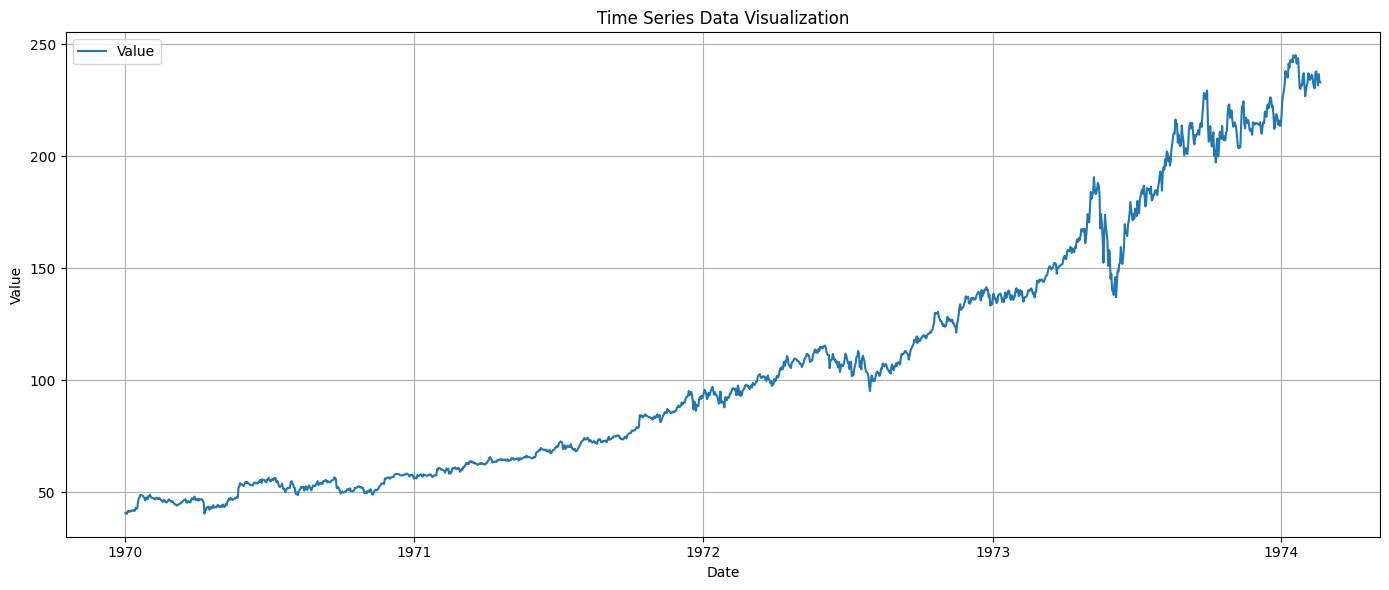

In [145]:
# พลอตกราฟ Time series data
plt.figure(figsize=(14, 6))
plt.plot(data['Value'], label='Value')
plt.title('Time Series Data Visualization')
plt.xlabel('Date')
plt.ylabel('Value')

# ปรับช่วงของแกน X ให้แสดงแค่ปี
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

check ความเป็น Stationarity ของข้อมูล

In [126]:
from statsmodels.tsa.stattools import adfuller # นำเข้าไลบรารี statsmodels.tsa.stattools เพื่อเรียกใช้ adfuller

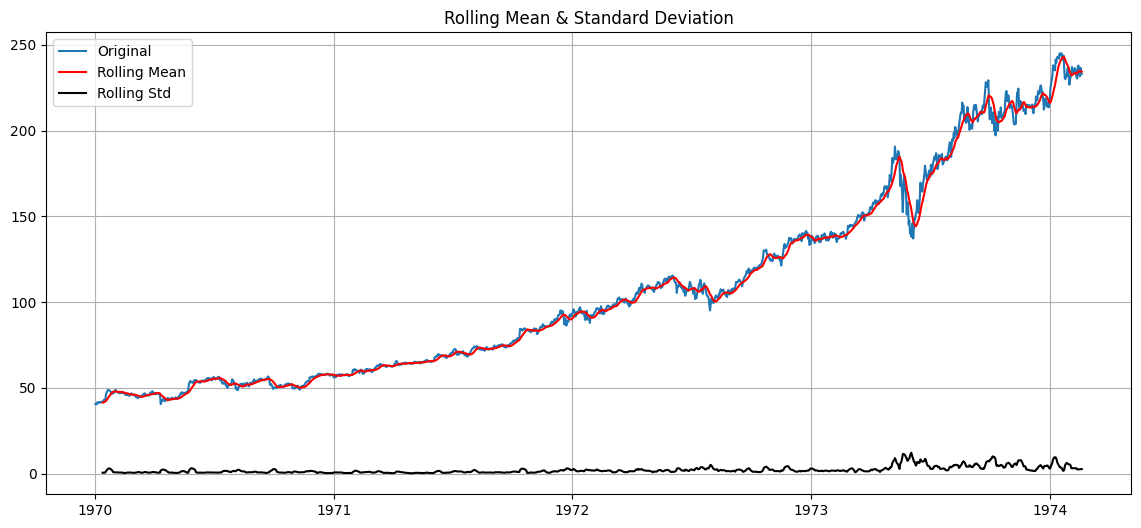

Test Statistic                    0.823915
p-value                           0.992013
# Lags Used                       2.000000
Number of Observations Used    1508.000000
Critical Value (1%)              -3.434694
Critical Value (5%)              -2.863459
Critical Value (10%)             -2.567791
dtype: float64

In [127]:
# ทำ Augmented Dickey-Fuller test
adf_result = adfuller(data['Value'])
adf_summary = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])

# สร้างค่าวิกฤตเพื่อสรุปผล
for key,value in adf_result[4].items():
    adf_summary[f'Critical Value ({key})'] = value

# พลอต rolling statistics
rolling_mean = data['Value'].rolling(window=12).mean()
rolling_std = data['Value'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(data['Value'], label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.show()

adf_summary

เนื่องจากมีค่า p-value ที่สูง (0.992013) เราจึงไม่สามารถปฏิเสธสมมติฐานว่าไม่มีการเปลี่ยนแปลง ซึ่งบ่งบอกว่าข้อมูลเป็น non-stationary (ไม่คงที่) 

และจากกราฟของค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานที่ไหลไปในทิศทางเดียวกันยังแสดงให้เห็นถึงความไม่คงที่ของข้อมูลเช่นกัน, เนื่องจากทั้งค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานไม่คงที่ตลอดระยะเวลา

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">2. ทำให้ข้อมูลเป็น Stationary</h1>

เราสามารถทำให้ข้อมูลเป็น stationary ได้ด้วยการทำ differencing กับข้อมูล ลองจากการทำ 1 ครั้งก่อน

In [128]:
# ดิฟ 1 ครั้ง
data_diff = data['Value'].diff().dropna()
data_diff

Date
4/2/2015 16:00:00     0.06
4/6/2015 16:00:00    -0.32
4/7/2015 16:00:00     1.27
4/8/2015 16:00:00    -0.13
4/9/2015 16:00:00    -0.23
                      ... 
3/25/2021 16:00:00   -2.55
3/26/2021 16:00:00   -3.75
3/29/2021 16:00:00    5.04
3/30/2021 16:00:00   -3.06
3/31/2021 16:00:00   -0.62
Name: Value, Length: 1510, dtype: float64

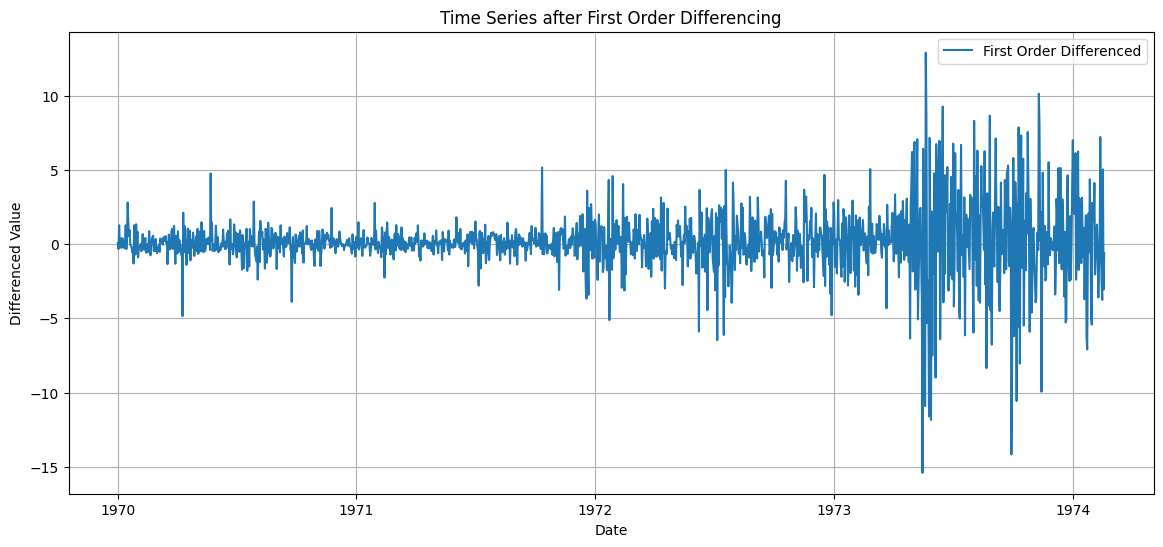

Test Statistic                -9.913565e+00
p-value                        3.122658e-17
# Lags Used                    2.400000e+01
Number of Observations Used    1.485000e+03
Critical Value (1%)           -3.434761e+00
Critical Value (5%)           -2.863488e+00
Critical Value (10%)          -2.567807e+00
dtype: float64

In [129]:
#  ทำ Augmented Dickey-Fuller test อีกรอบ
adf_result_diff = adfuller(data_diff)
adf_summary_diff = pd.Series(adf_result_diff[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in adf_result_diff[4].items():
    adf_summary_diff[f'Critical Value ({key})'] = value

# พลอต data ที่ดิฟแล้ว
plt.figure(figsize=(14, 6))
plt.plot(data_diff, label='First Order Differenced')
plt.title('Time Series after First Order Differencing')
plt.xlabel('Date')
plt.ylabel('Differenced Value')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.legend()
plt.grid(True)
plt.show()

adf_summary_diff

เนื่องจาก a p-value มีค่าน้อยกว่า 0.05 เราจึงสามารถปฏิเสธสมมติฐาน (null hypothesis) นั่นคือข้อมูลของเราเป็น stationary แล้ว

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">3. การวิเคราะห์ฤดูกาลและแนวโน้ม (Seasonality and Trend Analysis) </h1>

In [130]:
from statsmodels.tsa.seasonal import seasonal_decompose # นำเข้าไลบรารี statsmodels.tsa.seasonal เพื่อเรียกใช้ seasonal_decompose

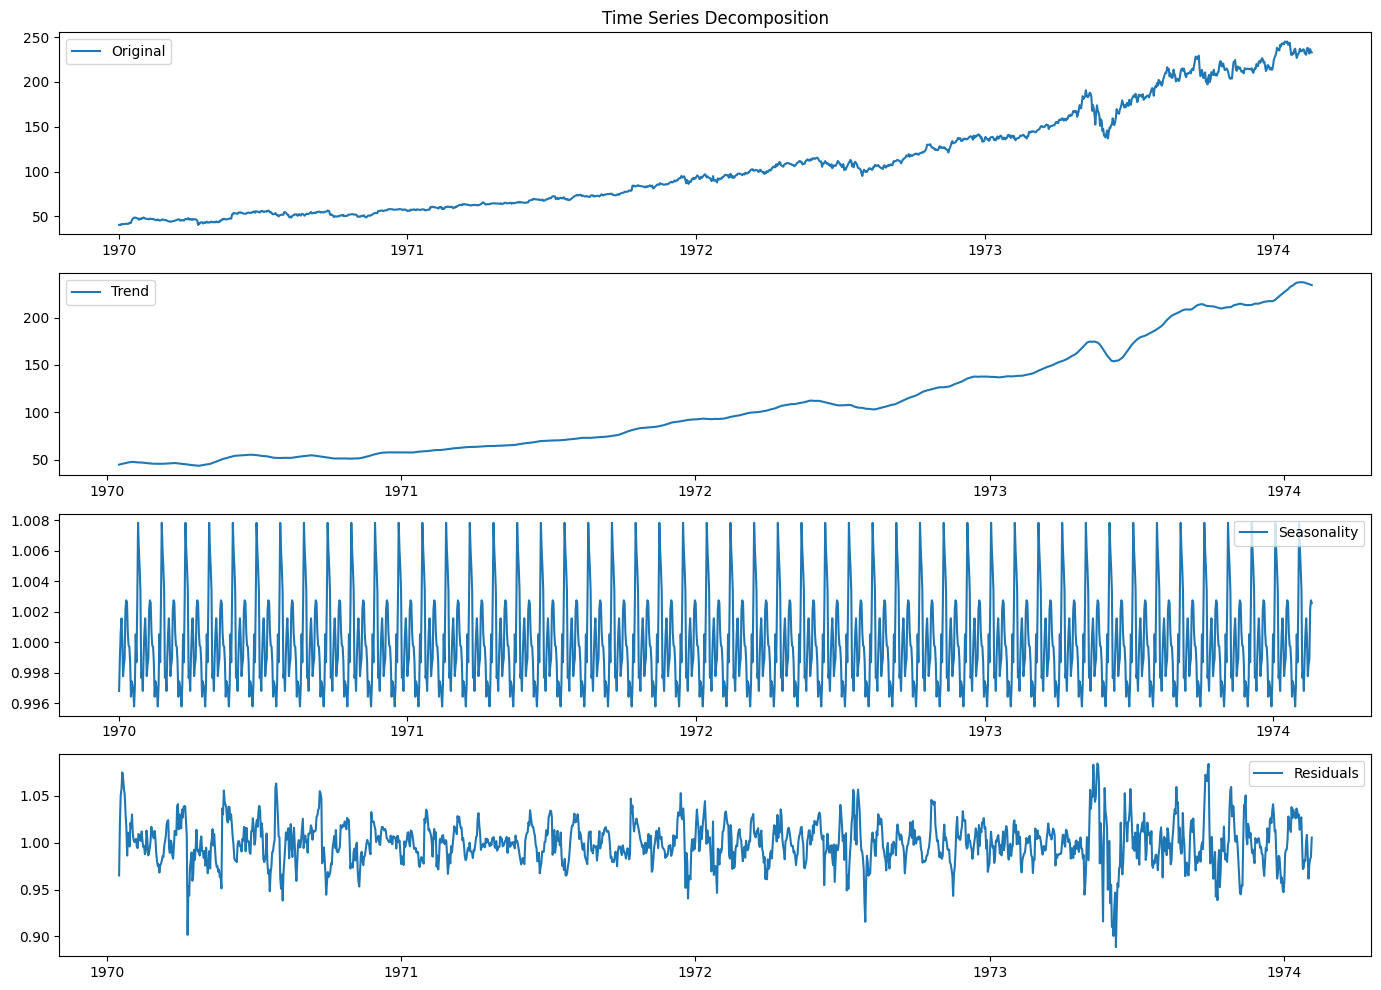

In [131]:
# แตกข้อมูล Time series
decomposition = seasonal_decompose(data['Value'], model='multiplicative', period=30) 

# พลอตข้อมูลเดิม, แนวโน้ม, ฤดูกาลและองค์ประกอบอื่นๆ
plt.figure(figsize=(14, 10))

plt.subplot(4,1,1)
plt.plot(data['Value'], label='Original')
plt.legend(loc='best')
plt.title('Time Series Decomposition')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.subplot(4,1,2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.subplot(4,1,4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.tight_layout()
plt.show()

- Trend: แนวโน้มหรือทิศทางของข้อมูล
- Seasonality: รูปแบบซ้ำๆที่อยู่ในข้อมูล ส่วนมากไว้ใช้ปรับ frequency ที่ดีที่สุดใน ARIMA model.
- Residuals: ข้อมูลที่หลงเหลือจากการแยกส่วนข้อมูลออกมาเป็น Trend และ Seasonality

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">5. การวิเคราะห์สหสัมพันธ์อัตโนมัติ (Autocorrelation Analysis)</h1>

การวิเคราะห์สหสัมพันธ์มีเป้าหมายในการทดสอบและวิเคราะห์ความสัมพันธ์ระหว่างข้อมูลที่มีลักษณะเป็นชุดเวลา (time series) ด้วยการพิจารณาความสัมพันธ์ที่มีต่อกันระหว่างจุดข้อมูลต่าง ๆ ในช่วงเวลาต่าง ๆ


- ACF (Autocorrelation Function): คือฟังก์ชันที่วัดความสัมพันธ์ระหว่างข้อมูลและ lag (หรือข้อมูลที่ถูกลากมา) ของมันเอง โดย ACF จะช่วยบอกเราว่าแต่ละ lag มีความสัมพันธ์กับข้อมูลมากน้อยเพียงใด

- PACF (Partial Autocorrelation Function): คือฟังก์ชันที่วัดความสัมพันธ์ระหว่างข้อมูลและ lag ของมันเอง โดยที่ไม่สนใจความสัมพันธ์ที่เกิดจากข้อมูลที่มี lag น้อยกว่า ซึ่ง PACF จะช่วยเราดูว่าความสัมพันธ์ที่เกิดขึ้นนั้นเป็นผลมาจากข้อมูลที่มี lag น้อยกว่าหรือไม่
การทำ ACF Plot และ PACF Plot ช่วยให้เราเข้าใจถึงความสัมพันธ์ระหว่างข้อมูลและ lag ของมันเอง และสามารถนำมาเป็นเครื่องมือในการเลือกค่า  p และ q สำหรับการสร้างโมเดล ARIMA ได้


In [132]:
# นำเข้าไลบรารี statsmodels.graphics.tsaplots เพื่อเรียกใช้ plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

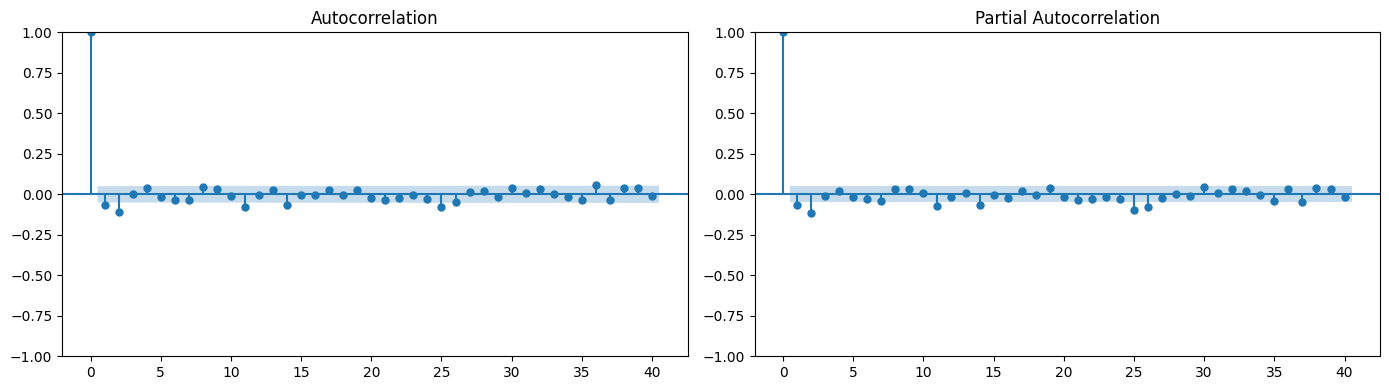

In [133]:
# พลอต ACF และ PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(data_diff, lags=40, ax=ax[0])
plot_pacf(data_diff, lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">6. แบ่งส่วนข้อมูล (Train-Test Split)</h1>

In [134]:
# แบ่งส่วนข้อมูลให้เป็น Train และ Test ในอัตราส่วน 80:20
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

<h1 style="font-size: 25px; font-weight: bold; font-family: Helvetica">7. การทำนายข้อมูลอนุกรมเวลาด้วย ARIMA model (Time Series forecasting with ARIMA model)</h1>

<h1 style="font-size: 18px;">7.1 forecast ด้วย ARIMA model และวัดผล</h1>

In [135]:
# นำเข้าไลบรารี statsmodels.tsa.statespace.sarimax เพื่อเรียกใช้ SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
# นำเข้าไลบรารี sklearn.metrics เพื่อเรียกใช้ mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [136]:
# กำหนดให้ค่าพารามิเตอร์ (p, d, q, s) ของโมเดล โดยอาจเปลี่ยนแปลงได้ภายหลัง
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  

# สร้าง ARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)

In [137]:
# เทรนโมเดล
model_fit = model.fit(disp=False)

In [138]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                 1208
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1903.159
Date:                            Fri, 06 Oct 2023   AIC                           3816.317
Time:                                    11:28:47   BIC                           3841.688
Sample:                                         0   HQIC                          3825.882
                                           - 1208                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0825      0.157      0.526      0.599      -0.225       0.390
ma.L1         -0.2207      0.152     -1.449      0.147      -0.519       0.078
ar.S.L12    1.779e-07      0.022   7.94e-06      1.000      -0.044       0.044
ma.S.L12      -0.9807      0.011    -88.415      0.000      -1.002      -0.959
sigma2         1.4325      0.037     39.134      0.000       1.361       1.504
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               919.96
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.14   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
# ทำนายอนาคต
predictions = model_fit.forecast(steps=len(test))

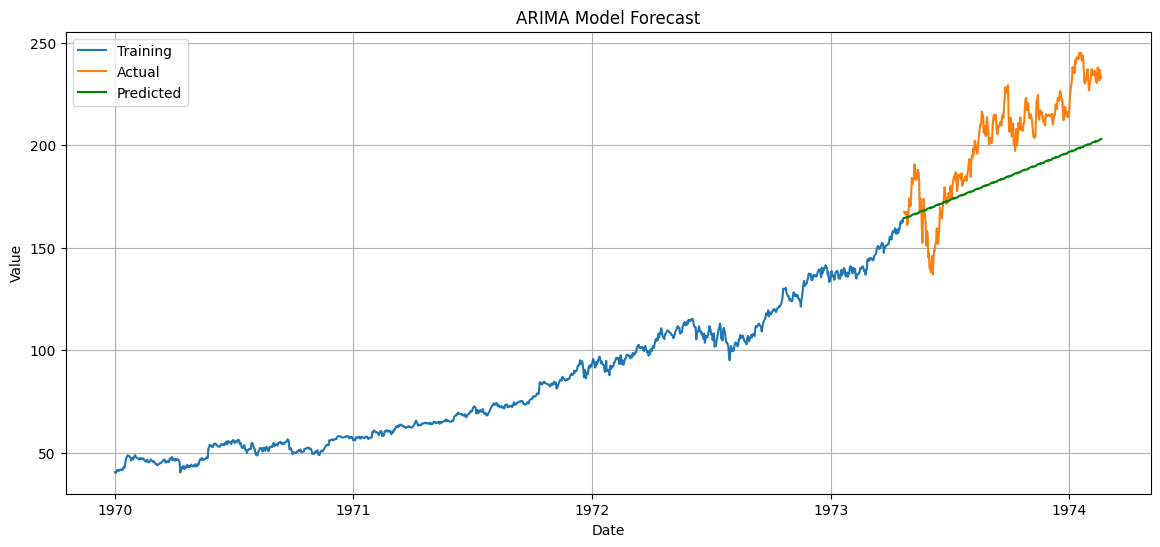

(21.65746676044843, 24.444754165716233)

In [143]:
# พลอตกราฟ
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='green')
plt.legend(loc='upper left')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.grid(True)
plt.show()

# วัดผลโมเดล
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

(mae, rmse)